# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [4]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS_PCP_forecasts_Sums_CMS.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS_TMP_forecasts_Avgs_K.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS_EVAP_forecasts_Sums_CMS.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [6]:
X = pd.DataFrame({
    'su_pcp_w': pcp_data['sup_lake'],
    'er_pcp_w': pcp_data['eri_lake'],
    'on_pcp_w': pcp_data['ont_lake'],
    'mh_pcp_w': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_pcp_l': pcp_data['sup_land'],
    'er_pcp_l': pcp_data['eri_land'],
    'on_pcp_l': pcp_data['ont_land'],
    'mh_pcp_l': pcp_data['mic_land']+pcp_data['hur_land'],
    'su_evap_w': evap_data['sup_lake'],
    'er_evap_w': evap_data['eri_lake'],
    'on_evap_w': evap_data['ont_lake'],
    'mh_evap_w': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_evap_l': evap_data['sup_land'],
    'er_evap_l': evap_data['eri_land'],
    'on_evap_l': evap_data['ont_land'],
    'mh_evap_l': evap_data['mic_land']+evap_data['hur_land'],
    'su_tmp_w': tmp_data['sup_lake'],
    'er_tmp_w': tmp_data['eri_lake'],
    'on_tmp_w': tmp_data['ont_lake'],
    'mh_tmp_w': (tmp_data['mic_lake']+tmp_data['hur_lake'])/2,
    'su_tmp_l': tmp_data['sup_land'],
    'er_tmp_l': tmp_data['eri_land'],
    'on_tmp_l': tmp_data['ont_land'],
    'mh_tmp_l': (tmp_data['mic_land']+tmp_data['hur_land'])/2
})
print(X)

         su_pcp_w    er_pcp_w    on_pcp_w     mh_pcp_w     su_pcp_l  \
0      636.369837  300.622778   63.822853  2466.485814  1652.077148   
1     2744.115733  375.388680  181.523281  2534.983177  6302.072992   
2     2605.488977  540.368897  271.529871  5117.100000  5124.974193   
3     2062.170153  677.219713  298.480950  2658.118961  4207.967037   
4     1852.993242  532.976397  292.464141  2550.001095  2882.919665   
...           ...         ...         ...          ...          ...   
2132  1690.325117  551.967312  293.463991  2542.295275  2789.370265   
2133  1463.935349  405.171747  200.465676  2146.633976  2814.223965   
2134  2389.472732  540.328969  268.308446  3964.111777  5073.034293   
2135   711.069834  439.149630   91.029991  2845.172214  2080.422379   
2136  1303.302512  397.833674  280.491368  3657.209591  3776.439484   

         er_pcp_l     on_pcp_l      mh_pcp_l    su_evap_w   er_evap_w  ...  \
0     2323.615451  1118.073131   7139.162678   902.196763  591.158547

Standardize the data

In [7]:
# Standardize the data
#scaler = StandardScaler()
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [8]:
# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['su_evap', 'su_precip', 'su_runoff', 'er_evap', 'er_precip', 'er_runoff',
                                          'on_evap', 'on_precip', 'on_runoff', 'mh_evap', 'mh_precip', 'mh_runoff'])
print(df_y_pred)

          su_evap    su_precip    su_runoff      er_evap   er_precip  \
0     1606.610352  1864.804066  1083.173354  1392.019081  892.702599   
1     2530.576262  3255.507588  1010.219212  1911.494320  850.886790   
2     3321.539056  2349.940053   775.118732  1840.266042  982.174860   
3     3448.345804  1717.723307   995.758400  1463.821046  992.490001   
4     4502.707929  1423.861294   560.196876  1114.369518  660.785555   
...           ...          ...          ...          ...         ...   
2132  3278.053424  1250.418398   361.274869   554.538724  726.398065   
2133  2756.297460  1106.249852   509.049458   531.121988  501.514066   
2134  1606.419608  1935.047713  1479.057388   611.166584  992.017383   
2135   870.511659  1158.300232  1399.557726   791.292002  899.133969   
2136   639.685497  1997.156940   979.802169  1081.481130  913.684307   

        er_runoff     on_evap   on_precip    on_runoff      mh_evap  \
0      405.563804  626.171053  494.249587   855.869115  1423.833

In [9]:
df = pd.DataFrame()
df['cfs_run'] = pcp_data['cfs_run'].astype(int)
df['forecast_month'] = pcp_data['forecast_month'].astype(int)
df['forecast_year'] = pcp_data['forecast_year'].astype(int)

In [10]:
df_y = pd.merge(df, df_y_pred, left_index=True, right_index=True, how='inner')

In [11]:
print(df_y)

         cfs_run  forecast_month  forecast_year      su_evap    su_precip  \
0     2024080100               8           2024  1606.610352  1864.804066   
1     2024080100               9           2024  2530.576262  3255.507588   
2     2024080100              10           2024  3321.539056  2349.940053   
3     2024080100              11           2024  3448.345804  1717.723307   
4     2024080100              12           2024  4502.707929  1423.861294   
...          ...             ...            ...          ...          ...   
2132  2024092218               2           2025  3278.053424  1250.418398   
2133  2024092218               3           2025  2756.297460  1106.249852   
2134  2024092218               4           2025  1606.419608  1935.047713   
2135  2024092218               5           2025   870.511659  1158.300232   
2136  2024092218               6           2025   639.685497  1997.156940   

        su_runoff      er_evap   er_precip    er_runoff     on_evap  \
0   

In [25]:
df_y['su_cnbs'] = df_y['su_precip'] + df_y['su_runoff'] - df_y['su_evap']
df_y['su_cnbs']  = df_y['su_precip'] + df_y['su_runoff'] - df_y['su_evap']
df_y['su_cnbs'] = df_y['su_precip'] + df_y['su_runoff'] - df_y['su_evap']

df_y['er_cnbs'] = df_y['er_precip'] + df_y['er_runoff'] - df_y['er_evap']
df_y['er_cnbs'] = df_y['er_precip'] + df_y['er_runoff'] - df_y['er_evap']
df_y['er_cnbs'] = df_y['er_precip'] + df_y['er_runoff'] - df_y['er_evap']

df_y['on_cnbs'] = df_y['on_precip'] + df_y['on_runoff'] - df_y['on_evap']
df_y['on_cnbs'] = df_y['on_precip'] + df_y['on_runoff'] - df_y['on_evap']
df_y['on_cnbs'] = df_y['on_precip'] + df_y['on_runoff'] - df_y['on_evap']

df_y['mh_cnbs'] = df_y['mh_precip'] + df_y['mh_runoff'] - df_y['mh_evap']
df_y['mh_cnbs'] = df_y['mh_precip'] + df_y['mh_runoff'] - df_y['mh_evap']
df_y['mh_cnbs'] = df_y['mh_precip'] + df_y['mh_runoff'] - df_y['mh_evap']

print(df_y)

         cfs_run  forecast_month  forecast_year      su_evap    su_precip  \
0     2024080100               8           2024  1606.610352  1864.804066   
1     2024080100               9           2024  2530.576262  3255.507588   
2     2024080100              10           2024  3321.539056  2349.940053   
3     2024080100              11           2024  3448.345804  1717.723307   
4     2024080100              12           2024  4502.707929  1423.861294   
...          ...             ...            ...          ...          ...   
2132  2024092218               2           2025  3278.053424  1250.418398   
2133  2024092218               3           2025  2756.297460  1106.249852   
2134  2024092218               4           2025  1606.419608  1935.047713   
2135  2024092218               5           2025   870.511659  1158.300232   
2136  2024092218               6           2025   639.685497  1997.156940   

        su_runoff      er_evap   er_precip    er_runoff     on_evap  \
0   

Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

In [26]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [27]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['forecast_year']), int(row['forecast_month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mh"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    return df_mm

In [28]:
current_month = datetime.now().month
current_year = datetime.now().year

filtered_y_pred = df_y[
    (df_y['forecast_year'] > current_year) |
    ((df_y['forecast_year'] == current_year) & (df_y['forecast_month'] >= current_month))
]
filtered_y_pred.to_csv(dir+f'CNBS_forecasts_cms.csv',sep=',',index=False)
months = pd.DataFrame(filtered_y_pred['forecast_month']).reset_index(drop=True)

In [29]:
df_y_mm = convert_cms_to_mm(filtered_y_pred)
print(df_y_mm)

months = pd.DataFrame(df_y_mm['forecast_month']).reset_index(drop=True)

         cfs_run  forecast_month  forecast_year     su_evap   su_precip  \
1     2024080100               9           2024   79.896387  102.784215   
2     2024080100              10           2024  108.364620   76.666376   
3     2024080100              11           2024  108.872581   54.232662   
4     2024080100              12           2024  146.900044   46.453221   
5     2024080100               1           2025  117.579294   48.091595   
...          ...             ...            ...         ...         ...   
2132  2024092218               2           2025   96.596305   36.846805   
2133  2024092218               3           2025   89.923714   36.091204   
2134  2024092218               4           2025   50.718536   61.094116   
2135  2024092218               5           2025   28.400288   37.789339   
2136  2024092218               6           2025   20.196412   63.055054   

      su_runoff     er_evap   er_precip   er_runoff     on_evap   on_precip  \
1     31.895053  193

In [31]:
def mean_min_max(df,lake):
    mean = df.groupby(['forecast_year', 'forecast_month'])[lake].mean().reset_index()
    min = df.groupby(['forecast_year', 'forecast_month'])[lake].min().reset_index()
    max = df.groupby(['forecast_year', 'forecast_month'])[lake].max().reset_index()

    return mean, min, max

mean_su_evap, min_su_evap, max_su_evap = mean_min_max(df_y_mm,'su_evap')
mean_su_precip, min_su_precip, max_su_precip = mean_min_max(df_y_mm,'su_precip')
mean_su_runoff, min_su_runoff, max_su_runoff = mean_min_max(df_y_mm,'su_runoff')
mean_su_cnbs, min_su_cnbs, max_su_cnbs = mean_min_max(df_y_mm,'su_cnbs')

mean_er_evap, min_er_evap, max_er_evap = mean_min_max(df_y_mm,'er_evap')
mean_er_precip, min_er_precip, max_er_precip = mean_min_max(df_y_mm,'er_precip')
mean_er_runoff, min_er_runoff, max_er_runoff = mean_min_max(df_y_mm,'er_runoff')
mean_er_cnbs, min_er_cnbs, max_er_cnbs = mean_min_max(df_y_mm,'er_cnbs')

mean_on_evap, min_on_evap, max_on_evap = mean_min_max(df_y_mm,'on_evap')
mean_on_precip, min_on_precip, max_on_precip = mean_min_max(df_y_mm,'on_precip')
mean_on_runoff, min_on_runoff, max_on_runoff = mean_min_max(df_y_mm,'on_runoff')
mean_on_cnbs, min_on_cnbs, max_on_cnbs = mean_min_max(df_y_mm,'on_cnbs')

mean_mh_evap, min_mh_evap, max_mh_evap = mean_min_max(df_y_mm,'mh_evap')
mean_mh_precip, min_mh_precip, max_mh_precip = mean_min_max(df_y_mm,'mh_precip')
mean_mh_runoff, min_mh_runoff, max_mh_runoff = mean_min_max(df_y_mm,'mh_runoff')
mean_mh_cnbs, min_mh_cnbs, max_mh_cnbs = mean_min_max(df_y_mm,'mh_cnbs')

In [32]:
print(mean_mh_cnbs)

   forecast_year  forecast_month     mh_cnbs
0           2024               9   61.400361
1           2024              10   40.421419
2           2024              11   25.343587
3           2024              12   17.123567
4           2025               1   22.217608
5           2025               2   30.714911
6           2025               3   65.167174
7           2025               4  109.550700
8           2025               5  129.558987
9           2025               6  124.929360


In [59]:
def plot_cnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(20, 10), sharex=True)#, sharey=True)
    axs = axs.flatten()
    
    row_labels = ['Lake Superior', 'Lake Mich-Huron', 'Lake Erie', 'Lake Ontario']
    column_labels = ['Precipitation [mm]', 'Evaporation [mm]', 'Runoff [mm]', 'CNBS [mm]']

    # Initialize lists to hold y min and max values to set y limits later
    y_limits = {
        'cnbs': [float('inf'), -float('inf')],
        'other': [float('inf'), -float('inf')],
    }

    # First pass to find the global min and max for each group
    for i, (category, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        if i in [3, 7, 11, 15]:
            y_limits['cnbs'][0] = min(y_limits['cnbs'][0], min_val.min())
            y_limits['cnbs'][1] = max(y_limits['cnbs'][1], max_val.max())
        else:
            y_limits['other'][0] = min(y_limits['other'][0], min_val.min())
            y_limits['other'][1] = max(y_limits['other'][1], max_val.max())

    # Plot each dataset
    for i, (category, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        axs[i].plot(x_values, mean, color='red', marker='o', markersize = 1.5, linestyle='-', linewidth=1, label='Mean')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2)
        axs[i].set_xlim(0, 9)  # Setting x-axis limits from 1 to 10
        axs[i].grid(True, linestyle='--', alpha=0.6)
        
        if i in [3, 7, 11, 15]:  # Apply y-limits
            axs[i].set_ylim(y_limits['cnbs'][0]-50, y_limits['cnbs'][1]+50)
        else:
            axs[i].set_ylim(0, y_limits['other'][1]+50)

        if i >= 12:  # Set labels for the last subplot
            axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][0]], calendar.month_abbr[months['forecast_month'][1]],
                                    calendar.month_abbr[months['forecast_month'][2]], calendar.month_abbr[months['forecast_month'][3]],
                                    calendar.month_abbr[months['forecast_month'][4]], calendar.month_abbr[months['forecast_month'][5]],
                                    calendar.month_abbr[months['forecast_month'][6]], calendar.month_abbr[months['forecast_month'][7]],
                                    calendar.month_abbr[months['forecast_month'][8]], calendar.month_abbr[months['forecast_month'][9]]])

    # Add row labels on the left side        
    for i in range(4):
            axs[i * 4].set_ylabel(row_labels[i], rotation=90, labelpad=10, fontsize=12)
    
    # Add column labels on the top
    for i in range(4):
        axs[i].set_title(column_labels[i], pad=10, fontsize=12)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(dir+f'CNBS_forecasts.png', bbox_inches='tight')
    plt.show()

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_5496\3349642123.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][0]], calendar.month_abbr[months['forecast_month'][1]],
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_5496\3349642123.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][0]], calendar.month_abbr[months['forecast_month'][1]],
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_5496\3349642123.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[months['forecast_month'][0]], calendar.month_abbr[months['forecast_month'][1]],
C:\Users\fitz

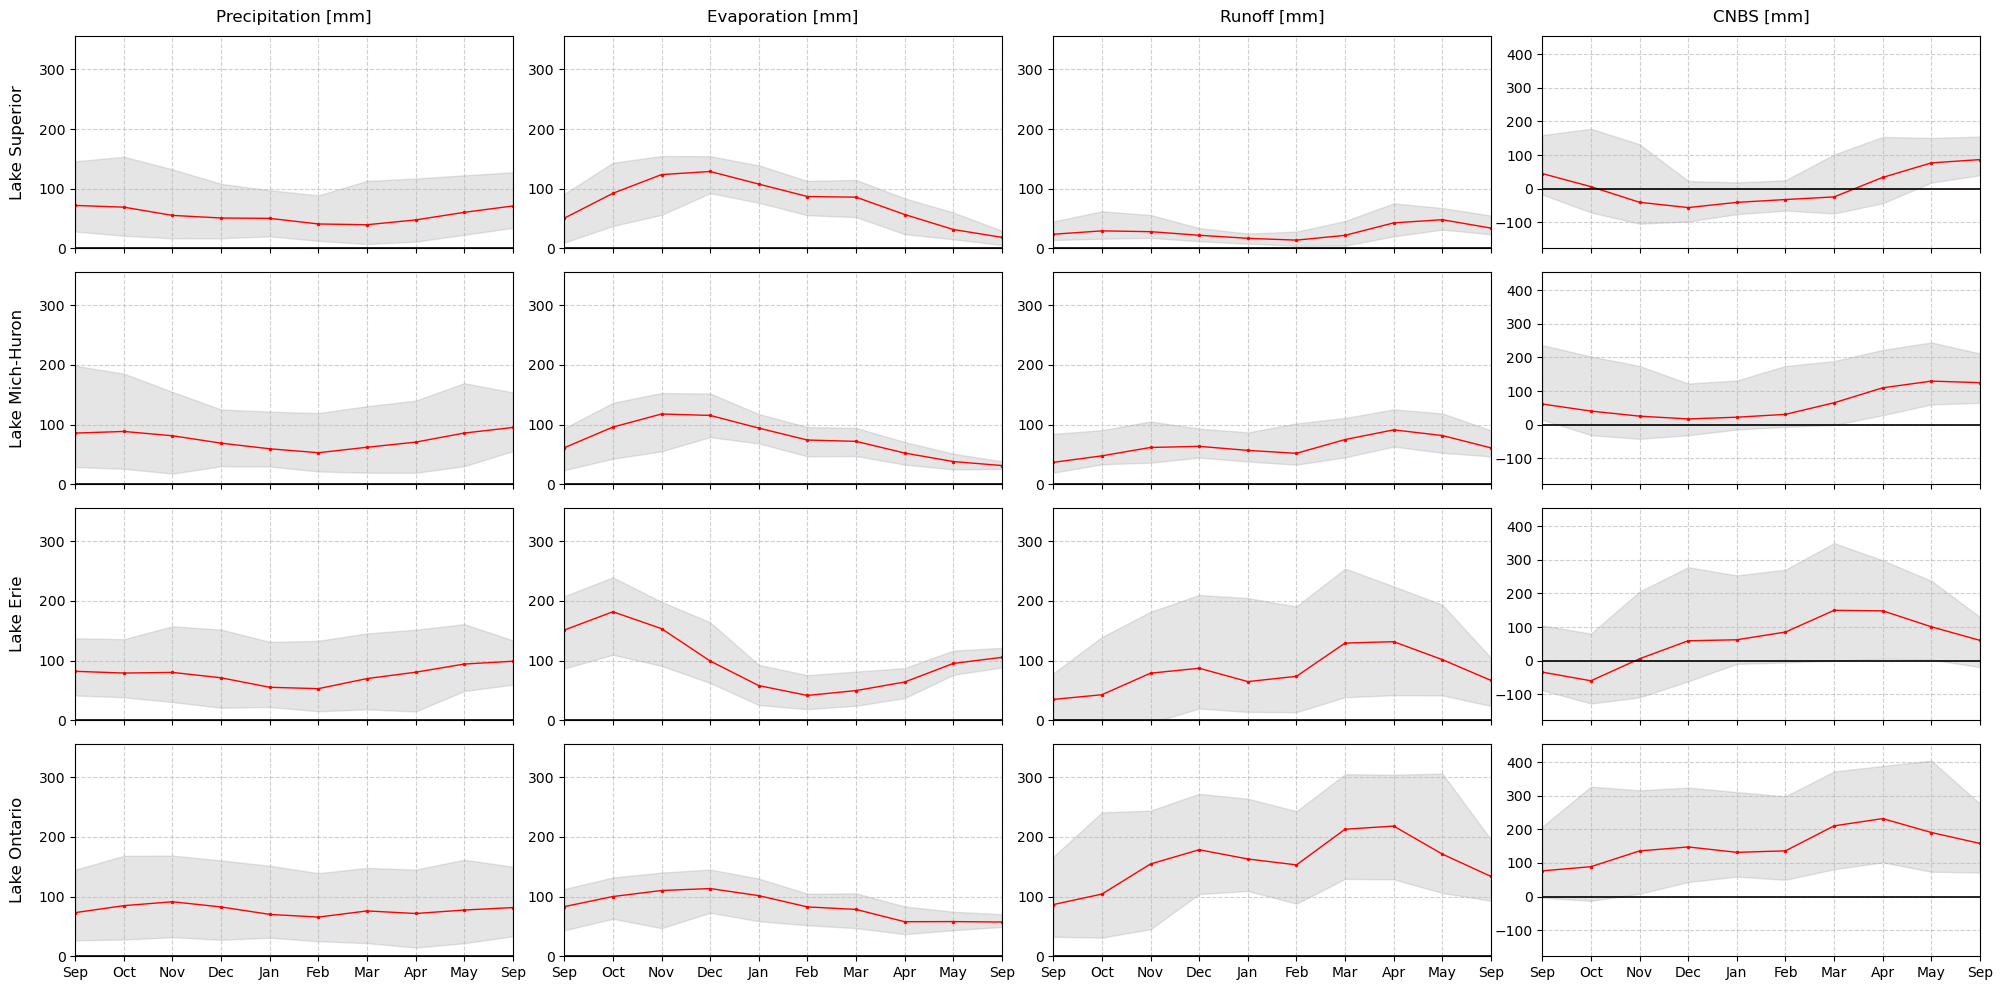

In [60]:
x_values = np.arange(len(mean_su_precip['su_precip']))  # x-axis values
data_dict = {
    'Superior P': (mean_su_precip['su_precip'], min_su_precip['su_precip'], max_su_precip['su_precip']),
    'Superior E': (mean_su_evap['su_evap'], min_su_evap['su_evap'], max_su_evap['su_evap']),
    'Superior R': (mean_su_runoff['su_runoff'], min_su_runoff['su_runoff'], max_su_runoff['su_runoff']),
    'Superior CNBS': (mean_su_cnbs['su_cnbs'], min_su_cnbs['su_cnbs'], max_su_cnbs['su_cnbs']),
    'Mich-Huron P': (mean_mh_precip['mh_precip'], min_mh_precip['mh_precip'], max_mh_precip['mh_precip']),
    'Mich-Huron E': (mean_mh_evap['mh_evap'], min_mh_evap['mh_evap'], max_mh_evap['mh_evap']),
    'Mich-Huron R': (mean_mh_runoff['mh_runoff'], min_mh_runoff['mh_runoff'], max_mh_runoff['mh_runoff']),
    'Mich-Huron CNBS': (mean_mh_cnbs['mh_cnbs'], min_mh_cnbs['mh_cnbs'], max_mh_cnbs['mh_cnbs']),
    'Erie P': (mean_er_precip['er_precip'], min_er_precip['er_precip'], max_er_precip['er_precip']),
    'Erie E': (mean_er_evap['er_evap'], min_er_evap['er_evap'], max_er_evap['er_evap']),
    'Erie R': (mean_er_runoff['er_runoff'], min_er_runoff['er_runoff'], max_er_runoff['er_runoff']),
    'Erie CNBS': (mean_er_cnbs['er_cnbs'], min_er_cnbs['er_cnbs'], max_er_cnbs['er_cnbs']),
    'Ontario P': (mean_on_precip['on_precip'], min_on_precip['on_precip'], max_on_precip['on_precip']),
    'Ontario E': (mean_on_evap['on_evap'], min_on_evap['on_evap'], max_on_evap['on_evap']),
    'Ontario R': (mean_on_runoff['on_runoff'], min_on_runoff['on_runoff'], max_on_runoff['on_runoff']),
    'Ontario CNBS': (mean_on_cnbs['on_cnbs'], min_on_cnbs['on_cnbs'], max_on_cnbs['on_cnbs'])
}

plot_cnbs_forecast(x_values, data_dict)